In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from scipy.ndimage import gaussian_filter, rotate
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader

T = torch.from_numpy
TD = TensorDataset
DL = DataLoader

import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('../modules_for_nn_training')
from learner import Learner
from callbacks import CallbackHandler
from utility_callbacks import LossCallback, MulticlassAccuracyCallback
from trainer import Trainer

from tqdm import tqdm_notebook

In [4]:
(x_train, y_train), (x_test, y_test) = load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

train_random_indices = np.random.choice(np.arange(len(x_train)), size=200, replace=False)
valid_random_indices = np.random.choice(np.arange(len(x_test)), size=1000, replace=False)

x_train = x_train[train_random_indices]
y_train = y_train[train_random_indices]

x_test = x_test[valid_random_indices]
y_test = y_test[valid_random_indices]

# x_train = x_train[np.logical_or(y_train == 5, y_train == 6)]
# y_train = y_train[np.logical_or(y_train == 5, y_train == 6)]

# x_test = x_test[np.logical_or(y_test == 5, y_test == 6)]
# y_test = y_test[np.logical_or(y_test == 5, y_test == 6)]

# y_train[y_train == 5] = 0
# y_train[y_train == 6] = 1

# y_test[y_test == 5] = 0
# y_test[y_test == 6] = 1

x_train = x_train - x_train.mean()
x_train = x_train / x_train.std()
x_test = x_test - x_test.mean()
x_test = x_test / x_test.std()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train.min(), x_train.max(), x_test.min(), x_test.max())
print(y_train.min(), y_train.max(), y_test.min(), y_test.max())

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(200, 28, 28) (200,) (1000, 28, 28) (1000,)
-0.4276877907676273 2.8042917223173736 -0.425335044157851 2.806888276054866
0 9 0 9


In [5]:
x_train_modified = []
np.random.seed(42)
degrees_to_rotate = np.random.choice(np.arange(-30, 31, 10), size=len(x_train))
for x, deg in tqdm_notebook(list(zip(x_train, degrees_to_rotate))):
    x = gaussian_filter(x, 1/2)
    x_train_modified.append(rotate(x, deg, reshape=False, mode='nearest'))
x_train_modified = np.array(x_train_modified)

In [6]:
x_test_modified = []
np.random.seed(42)
degrees_to_rotate = np.random.choice(np.arange(-30, 31, 1), size=len(x_test))
for x, deg in tqdm_notebook(list(zip(x_test, degrees_to_rotate))):
    x = gaussian_filter(x, 1/2)
    x_test_modified.append(rotate(x, deg, reshape=False, mode='nearest'))
x_test_modified = np.array(x_test_modified)

## Tangent vector by finite difference

In [14]:
angle = 1e-4

In [15]:
def get_tangent_vector(x:np.array)->np.array:
    digit = x.reshape(28, 28)
    left_rotated_digit = rotate(digit, angle, reshape=False, mode='nearest')
    right_rotated_digit = rotate(digit, -angle, reshape=False, mode='nearest')
    tangent_vector = (left_rotated_digit - right_rotated_digit) / (2 * angle)
    return tangent_vector

In [16]:
def show_digit(digit):
    plt.imshow(digit, cmap='gray_r')
    plt.show()

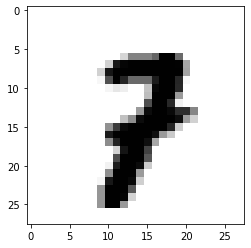

In [17]:
some_digit = x_train[1]
show_digit(some_digit)

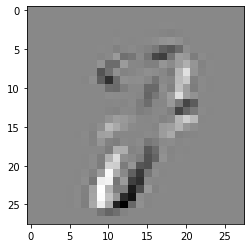

In [18]:
tangent_vector = get_tangent_vector(some_digit.flatten())
show_digit(tangent_vector)

## Jacobian computation

In [19]:
def get_jacobian(net, x, noutputs):
    x_dup = x.repeat(noutputs, 1)
    x_dup.requires_grad_(True)
    y = net(x_dup)
    grad_params = torch.autograd.grad(y, x_dup, torch.eye(noutputs), create_graph=True)
    return grad_params[0]

In [310]:
input = T(some_digit.flatten())
input.requires_grad=True

In [311]:
multiplier = torch.tensor([3.], requires_grad=True)

In [26]:
grad_params = get_jacobian(lambda x : multiplier * x, input, 28 * 28)

AttributeError: 'function' object has no attribute 'named_parameters'

In [ ]:
for grad in grad_params:
    result = torch.norm(grad @ torch.randn(784, 1).double())

In [27]:
result.backward()

NameError: name 'result' is not defined

In [28]:
multiplier.grad

In [21]:
multiplier

tensor([3.], requires_grad=True)

In [22]:
multiplier.grad = None

In [393]:
new.requires_grad = True

In [394]:
sum = torch.sum(new)

In [395]:
sum.backward()

In [396]:
multiplier.grad

In [376]:
new.grad

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], dtype=torch.float64)

In [326]:
multiplier.grad, input.grad

(tensor([-111.0579]), None)

In [327]:
multiplier.grad = None

## NN training

In [20]:
train_ds = TD(T(x_train_modified.reshape(200, 28 * 28)), T(y_train).long())
train_dl = DL(train_ds, batch_size=64, shuffle=True)

valid_ds = TD(T(x_test_modified.reshape(1000, 28 * 28)), T(y_test).long())
valid_dl = DL(valid_ds, batch_size=64, shuffle=False)

In [22]:
class NN(nn.Module):
    
    def __init__(self, num_neurons):
        
        super().__init__()
        
        self.main = nn.Sequential(
            
            nn.Linear(28 * 28, num_neurons),
            nn.BatchNorm1d(num_neurons),
            nn.ReLU(),
            
            nn.Linear(num_neurons, num_neurons),
            nn.BatchNorm1d(num_neurons),
            nn.ReLU(),
            
            nn.Linear(num_neurons, 10),
            nn.ReLU(),
        
        )
    
    def forward(self, xb):
        xb = self.main(xb)
        return xb.view(-1, 10)

In [23]:
def get_model(num_neurons):
    nn = NN(num_neurons)
    return nn, optim.Adam(nn.parameters(), lr=1e-4)

In [86]:
gd_test_accs = []
for i in tqdm_notebook(np.arange(20)):

    model, opt = get_model(300)
    loss = nn.CrossEntropyLoss()
    learn = Learner(train_dl, valid_dl, model, loss, opt)

    loss_cb = LossCallback()
    acc_cb = MulticlassAccuracyCallback()
    cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb])

    trainer = Trainer(learn=learn, cb_handler=cb_handler)
    # trainer.find_lr(beta=0.98, final_value=1e-1, num_itr=100)
    trainer.set_lr(2e-3)
    
    trainer.train(10)
    
    gd_test_accs.append(acc_cb.state_dict['accs'])

In [115]:
gd_test_accs

array([[0.432, 0.494, 0.54 , 0.583, 0.581, 0.598, 0.61 , 0.623, 0.625,
        0.627],
       [0.473, 0.538, 0.587, 0.596, 0.619, 0.647, 0.651, 0.67 , 0.676,
        0.688],
       [0.408, 0.477, 0.519, 0.517, 0.531, 0.562, 0.57 , 0.577, 0.581,
        0.556],
       [0.415, 0.462, 0.51 , 0.565, 0.576, 0.596, 0.601, 0.611, 0.606,
        0.6  ],
       [0.426, 0.534, 0.579, 0.62 , 0.664, 0.689, 0.667, 0.641, 0.641,
        0.649],
       [0.45 , 0.509, 0.529, 0.589, 0.629, 0.63 , 0.621, 0.624, 0.61 ,
        0.611],
       [0.508, 0.538, 0.581, 0.61 , 0.615, 0.621, 0.614, 0.645, 0.648,
        0.637],
       [0.458, 0.535, 0.605, 0.626, 0.63 , 0.65 , 0.659, 0.645, 0.648,
        0.66 ],
       [0.452, 0.496, 0.527, 0.532, 0.542, 0.581, 0.577, 0.595, 0.597,
        0.574],
       [0.487, 0.506, 0.511, 0.551, 0.584, 0.601, 0.62 , 0.625, 0.612,
        0.621],
       [0.481, 0.539, 0.577, 0.628, 0.611, 0.609, 0.599, 0.605, 0.63 ,
        0.656],
       [0.481, 0.507, 0.544, 0.558, 0.565, 

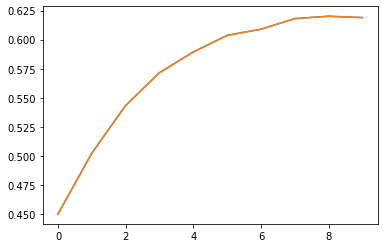

In [93]:
gd_test_accs = np.array(gd_test_accs)
plt.plot(np.arange(0, 10), gd_test_accs.mean(axis=0))
plt.errorbar(np.arange(0, 10), gd_test_accs.mean(axis=0))
plt.show()

In [46]:
# fig = plt.figure(figsize=(14, 4))

# ax = fig.add_subplot(121)
# loss_cb.plot()

# fig.add_subplot(122)
# acc_cb.plot()
# plt.yticks(np.arange(0, 1.1, 0.1))
# plt.ylim(0, 1)

# plt.show()

## Trainer with local-invariance loss

In [111]:
import numpy as np
from tqdm import tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
import torch

class TrainerM:
    
    def __init__(self, learn, cb_handler, mu):
        self.learn = learn
        self.cb_handler = cb_handler
        self.mu = mu
        
    @staticmethod
    def plot_lrs_and_losses(lrs, losses, lr_axis_min, lr_axis_max, show_suggestion):
        
        plt.plot(lrs, losses)
        
        if show_suggestion:  # does not work unless losses are rather smooth
            min_grad_idx = np.argmin(np.gradient(losses))
            plt.scatter(lrs[min_grad_idx], losses[min_grad_idx], color='red')
        
        plt.grid(which='major'); plt.grid(which='minor', axis='x')
        plt.xscale('log')
    
        # base 10 ticks is easier to read off of
        xticks = []
        value = lr_axis_min
        while value <= lr_axis_max:
            xticks.append(value)
            value *= 10
            
        plt.xticks(xticks)
        # reference: https://github.com/fastai/fastai/blob/3b7c453cfa3845c6ffc496dd4043c07f3919270e/fastai/basic_train.py#L540
        plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        
        plt.xlabel('Learning rate'); plt.ylabel('Loss')
        plt.show()
        
    def find_lr(self, init_value=1e-6, final_value=10, num_itr=200, beta=0.98, skip_start=10, skip_end=5, show_suggestion=False):
        
        self.save_as_pth('temp.pth')
        
        mult = (final_value / init_value) ** (1 / num_itr)
        lr = init_value
        
        for param_group in self.learn.opt.param_groups:
            param_group['lr'] = lr
        
        avg_loss = 0.
        best_loss = np.inf
        batch_num = 0
        losses = []
        lrs = []
        
        num_epochs = int(np.ceil(num_itr / len(self.learn.train_dl)))
        
        is_stop = False
        
        pbar = tqdm_notebook(total=num_itr)
        
        for epoch in range(num_epochs):
        
            for xb, yb in self.learn.train_dl:

                batch_num += 1
                pbar.update(1)
                if batch_num > num_itr: 
                    is_stop = True
                    break

                self.learn.model.train()
                    
                yhatb = self.learn.model(xb.float())
                lossb = self.learn.loss(yhatb, yb)
                
                for m in self.learn.model.modules():
                    if isinstance(m, nn.BatchNorm1d):
                        m.eval()
                
                local_invariance_loss = 0
                for x in xb:
                    jacobian = get_jacobian(self.learn.model, x.view(28 * 28).float(), 10)
                    tangent_vector = T(get_tangent_vector(np.array(x)).reshape(28 * 28, 1))
                    directional_derivative = jacobian @ tangent_vector.float()
                    norm = torch.sum(directional_derivative ** 2)
                    local_invariance_loss += norm
                local_invariance_loss /= xb.size(0)
                
                total_loss = lossb + 10 * local_invariance_loss
                
                # compute the smoothed loss
                avg_loss = beta * avg_loss + (1-beta) * float(total_loss)
                smoothed_loss = avg_loss / (1 - beta ** batch_num)
                
                # stop if the loss is exploding
                if smoothed_loss > 4 * best_loss: 
                    is_stop = True
                    break
                
                # record the best loss
                if smoothed_loss < best_loss: best_loss = smoothed_loss
                
                # store the values
                losses.append(smoothed_loss); lrs.append(lr)

                lossb.backward()
                self.learn.opt.step()
                self.learn.opt.zero_grad()

                lr *= mult
                for param_group in self.learn.opt.param_groups:
                    param_group['lr'] = lr
                    
            if is_stop: break
                
        self.plot_lrs_and_losses(
            lrs[skip_start:-skip_end], 
            losses[skip_start:-skip_end],
            init_value,
            final_value,
            show_suggestion
        )
        
        self.load_from_pth('temp.pth')
        
    def set_lr(self, lr):
        for param_group in self.learn.opt.param_groups:
            param_group['lr'] = lr
        
    def train(self, num_epoch=10):
        
        self.cb_handler.on_train_begin()
    
        for epoch in tqdm_notebook(range(num_epoch), desc='Overall Progress', leave=False):

            self.cb_handler.on_epoch_begin()

            # ========== train ==========

            for (xb, yb), (xb2, yb2) in tqdm_notebook(list(zip(self.learn.train_dl, self.learn.train_dl)), desc='Training', leave=False):
                
                self.learn.model.train()
                
                yhatb = self.learn.model(xb.float())
                lossb = self.learn.loss(yhatb, yb)
    
                for m in self.learn.model.modules():
                    if isinstance(m, nn.BatchNorm1d):
                        m.eval()
    
                local_invariance_loss = 0
                for x in xb:
                    jacobian = get_jacobian(self.learn.model, x.view(28 * 28).float(), 10)
                    tangent_vector = T(get_tangent_vector(np.array(x)).reshape(28 * 28, 1))
                    directional_derivative = jacobian @ tangent_vector.float()
                    norm = torch.sum(directional_derivative ** 2)
                    local_invariance_loss += norm
                local_invariance_loss /= xb.size(0)
                    
                total_loss = lossb + 10 * local_invariance_loss
                #print(f'Epoch: {epoch:<3} | Loss: {float(lossb):.2f} | Local invariance loss: {float(local_invariance_loss * 100):.3f}')
                
                total_loss.backward()
                self.learn.opt.step()
                self.learn.opt.zero_grad()
                
            # ========== validation ==========

            self.learn.model.eval()
            for xb, yb in tqdm_notebook(self.learn.valid_dl, desc='Validation', leave=False):
                
                self.cb_handler.on_batch_begin(yb=yb, bs=yb.size(0))  
                # yb: for computing accuracy (in AccuracyCallback)
                # bs: for weighting any metric
                
                yhatb = self.learn.model(xb.float())
                self.cb_handler.on_forward_end(yhatb=yhatb)  
                # yhatb: for computing accuracy (in AccuracyCallback)
                
                lossb = self.learn.loss(yhatb, yb)
                self.cb_handler.on_loss_end(lossb=lossb)  
                # lossb: for plotting loss  (in LossCallback)
                
                self.cb_handler.on_batch_end()
                
            self.cb_handler.on_epoch_end()
            
        self.cb_handler.on_train_end()
        
    def save_as_pth(self, path):
        torch.save(self.learn.model.state_dict(), path)
        
    def load_from_pth(self, path):
        self.learn.model.load_state_dict(torch.load(path))

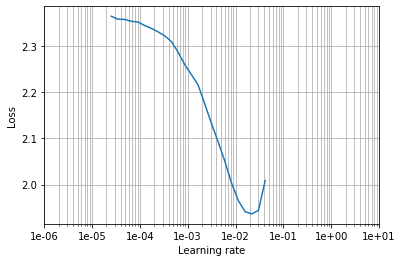

In [112]:
model, opt = get_model(300)
loss = nn.CrossEntropyLoss()
learn = Learner(train_dl, valid_dl, model, loss, opt)

loss_cb = LossCallback()
acc_cb = MulticlassAccuracyCallback()
cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb])

trainer = TrainerM(learn=learn, cb_handler=cb_handler, mu=0)
trainer.find_lr(beta=0.98, final_value=10, num_itr=50)

In [113]:
model, opt = get_model(300)
loss = nn.CrossEntropyLoss()
learn = Learner(train_dl, valid_dl, model, loss, opt)

loss_cb = LossCallback()
acc_cb = MulticlassAccuracyCallback()
cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb])

trainer = TrainerM(learn=learn, cb_handler=cb_handler, mu=0)
trainer.set_lr(2e-3)
trainer.train(10)

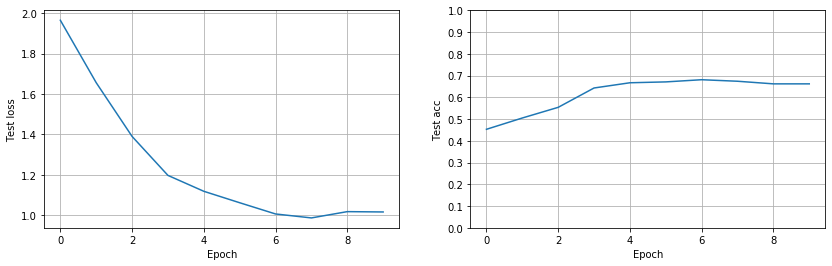

In [114]:
fig = plt.figure(figsize=(14, 4))

ax = fig.add_subplot(121)
loss_cb.plot()

fig.add_subplot(122)
acc_cb.plot()
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)

plt.show()

In [95]:
tp_test_accs = []
for i in tqdm_notebook(np.arange(10)):
    
    model, opt = get_model(300)
    loss = nn.CrossEntropyLoss()
    learn = Learner(train_dl, valid_dl, model, loss, opt)

    loss_cb = LossCallback()
    acc_cb = MulticlassAccuracyCallback()
    cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb])

    trainer = TrainerM(learn=learn, cb_handler=cb_handler, mu=0)
    trainer.set_lr(5e-3)
    trainer.train(10)
    
    tp_test_accs.append(acc_cb.state_dict['accs'])
tp_test_accs = np.array(tp_test_accs)

KeyboardInterrupt: 

In [96]:
tp_test_accs = np.array(tp_test_accs)

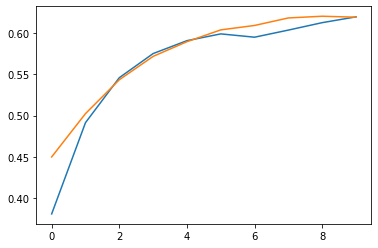

In [99]:
tp_test_accs = np.array(tp_test_accs)
plt.plot(np.arange(0, 10), tp_test_accs.mean(axis=0))

gd_test_accs = np.array(gd_test_accs)
plt.plot(np.arange(0, 10), gd_test_accs.mean(axis=0))

plt.show()

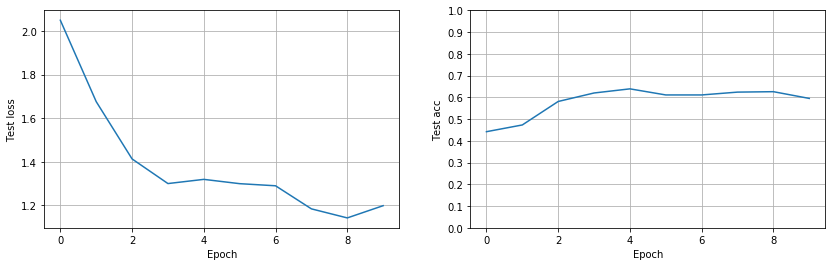

In [60]:
# fig = plt.figure(figsize=(14, 4))

# ax = fig.add_subplot(121)
# loss_cb.plot()

# fig.add_subplot(122)
# acc_cb.plot()
# plt.yticks(np.arange(0, 1.1, 0.1))
# plt.ylim(0, 1)

# plt.show()

In [562]:
trainer.save_as_pth('./tangent_prop_on_mnist_5_and_6_for_10_epochs.pth')

In [61]:
loss_cb.weighted_values

[]

In [61]:
acc_cb.state_dict['accs'][-1]

0.595